In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/HW3/test2")

In [0]:
from __future__ import print_function

import collections
import math

import random

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import convolution2d, fully_connected

import atari_wrappers           # from OpenAI Baselines
import gym                      # for the RL environments
import matplotlib.pyplot as plt # for plots
import h5py

In [0]:
env = atari_wrappers.wrap_deepmind(atari_wrappers.make_atari('SeaquestNoFrameskip-v4'),clip_rewards=True, frame_stack=True)  # gym.make('CartPole-v1')

In [0]:
import numpy as np
import h5py

class HDF5Store(object):
    """
    Simple class to append value to a hdf5 file on disc (usefull for building keras datasets)
    
    Params:
        datapath: filepath of h5 file
        dataset: dataset name within the file
        shape: dataset shape (not counting main/batch axis)
        dtype: numpy dtype
    
    Usage:
        hdf5_store = HDF5Store('/tmp/hdf5_store.h5','X', shape=(20,20,3))
        x = np.random.random(hdf5_store.shape)
        hdf5_store.append(x)
        hdf5_store.append(x)
        
    From https://gist.github.com/wassname/a0a75f133831eed1113d052c67cf8633
    """
    def __init__(self, datapath, dataset, shape, dtype=np.float32, compression="gzip", chunk_len=1):
        self.datapath = datapath
        self.dataset = dataset
        self.shape = shape
        self.i = 0
        
        with h5py.File(self.datapath, mode='w') as h5f:
            self.dset = h5f.create_dataset(
                dataset,
                shape=(0, ) + shape,
                maxshape=(None, ) + shape,
                dtype=dtype,
                compression=compression,
                chunks=(chunk_len, ) + shape)
    
    def append(self, values):
        with h5py.File(self.datapath, mode='a') as h5f:
            dset = h5f[self.dataset]
            dset.resize((self.i + 1, ) + shape)
            dset[self.i] = [values]
            self.i += 1
            h5f.flush()

In [0]:
shape = (1,5)
hdf5_store = HDF5Store('./test-LR-001-6.h5','X', shape=shape)

In [0]:
tf.reset_default_graph()

In [0]:
tf.reset_default_graph()
state_size = env.observation_space.shape
input_height = state_size[0]
input_width = state_size[1]
input_channels = state_size[2]
conv_n_maps = [16, 32]
conv_kernel_sizes = [(8,8), (4,4)]
conv_strides = [4, 2]
conv_paddings = ["SAME"] * 2 
conv_activation = [tf.nn.relu] * 2
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 256
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.variance_scaling_initializer()

def q_network(input_placeholder, name):
    mean, variance = tf.nn.moments(input_placeholder, axes=[0, 1, 2,3])
    inputs = (input_placeholder-mean)/(((variance)**0.5)+1e-7)
    prev_layer = inputs
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        flatten_dim = np.prod(prev_layer.get_shape().as_list()[1:])
        flatten = tf.reshape(prev_layer, [-1, flatten_dim])
        #last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(flatten, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    tf.identity(outputs, name='output')

    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    
    return outputs, trainable_vars_by_name

In [0]:
for op in tf.get_default_graph().get_operations():
    print(str(op.name))

In [10]:
input_placeholder = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels],name='input_placeholder')
online_q_values, online_vars = q_network(input_placeholder, name="q_networks/online")
target_q_values, target_vars = q_network(input_placeholder, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops) #input_placeholder X_state

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.


In [11]:
print(online_q_values)

Tensor("q_networks/online/dense_1/BiasAdd:0", shape=(?, 18), dtype=float32)


In [12]:
online_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(16,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 4, 16) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 16, 32) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(256,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(3872, 256) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(18,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/dense_1/kernel:0' shape=(256, 18) dtype=float32_ref>}

In [13]:
for op in tf.get_default_graph().get_operations():
    print(str(op.name))

input_placeholder
moments/mean/reduction_indices
moments/mean
moments/StopGradient
moments/SquaredDifference
moments/variance/reduction_indices
moments/variance
moments/Squeeze
moments/Squeeze_1
sub
pow/y
pow
add/y
add
truediv
q_networks/online/conv2d/kernel/Initializer/truncated_normal/shape
q_networks/online/conv2d/kernel/Initializer/truncated_normal/mean
q_networks/online/conv2d/kernel/Initializer/truncated_normal/stddev
q_networks/online/conv2d/kernel/Initializer/truncated_normal/TruncatedNormal
q_networks/online/conv2d/kernel/Initializer/truncated_normal/mul
q_networks/online/conv2d/kernel/Initializer/truncated_normal
q_networks/online/conv2d/kernel
q_networks/online/conv2d/kernel/Assign
q_networks/online/conv2d/kernel/read
q_networks/online/conv2d/bias/Initializer/zeros
q_networks/online/conv2d/bias
q_networks/online/conv2d/bias/Assign
q_networks/online/conv2d/bias/read
q_networks/online/conv2d/dilation_rate
q_networks/online/conv2d/Conv2D
q_networks/online/conv2d/BiasAdd
q_netwo

In [14]:
learning_rate = 0.01
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


In [0]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [0]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [0]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [0]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 1000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [0]:
n_steps = 1000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 27  # Skip the start of every game (it's just waiting time).
batch_size = 32
iteration = 0  # game iterations
checkpoint_path = "./homework_3"
done = True # env needs to be reset

In [0]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

In [0]:
def preprocess_observation(obs):
    #obs =np.expand_dims(np.array(obs, dtype=np.float32), axis=0)
    return obs

In [0]:
env = atari_wrappers.wrap_deepmind(atari_wrappers.make_atari('SeaquestNoFrameskip-v4'),clip_rewards=True, frame_stack=True)  # gym.make('CartPole-v1')

In [23]:
action_size = env.action_space.n
state = env.reset()
state, reward, done, _ = env.step(random.randrange(action_size))
obs=np.expand_dims(np.array(state, dtype=np.float32), axis=0)
print(obs[0,:,:,:].shape)

(84, 84, 4)


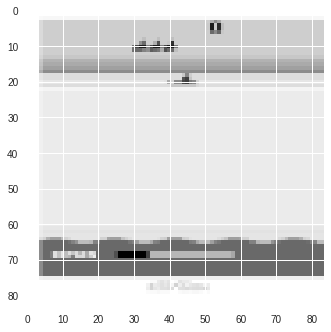

In [24]:
img=obs[0,:,:,3]
plt.imshow(img)

In [0]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    a = 0
    total_a=0
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print(
            "\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f} \tMean reward {:2f}  ".format(
                iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q, a), end="")

        if done:  # game over, start again

            obs = env.reset()
            for skip in range(skip_start):  # skip the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)
        # Online DQN evaluates what to do
        q_values = online_q_values.eval(
            feed_dict={input_placeholder: np.expand_dims(np.array(state, dtype=np.float32), axis=0)})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)
        if done:
            reward = -0.001

        if not done and reward == 0:
            reward = -1e-8
        #         if reward==1:
        #           reward+=0.5

        # Let's memorize what happened
        if np.expand_dims(np.array(state, dtype=np.float32), axis=0).all and np.expand_dims(
                np.array(next_state, dtype=np.float32), axis=0).all:
            replay_memory.append((state, action, reward, next_state, 1.0 - done))
            state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        a += reward
        total_a =total_a + reward
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0
            a = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue  # only train after warmup period and at regular intervals

        # Sample memories and use the target DQN to produce the target Q-Value
        a_state_val, X_action_val, rewards, b_next_state_val, continues = (sample_memories(batch_size))
        X_state_val = np.asarray(
            [np.expand_dims(np.array(i, dtype=np.float32), axis=0)[0, :, :, :] for i in a_state_val])
        X_next_state_val = np.asarray(
            [np.expand_dims(np.array(i, dtype=np.float32), axis=0)[0, :, :, :] for i in b_next_state_val])

        # print(X_state_val.shape,X_next_state_val.shape)
        next_q_values = np.asarray(target_q_values.eval(feed_dict={input_placeholder: X_next_state_val}))
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss],
                               feed_dict={input_placeholder: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)
            hdf5_store.append([iteration, step, mean_max_q, a, total_a])
            total_a=0

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./homework_3
Iteration 255404	Training step 670352/1000000 (67.0)%	Loss 0.030770	Mean Max-Q 3.257625 	Mean reward 2.999998  

In [0]:
hdf5_store.append([1,1,1,1])

In [0]:
frames = []
n_max_steps = 10000
a=0
total_a=0
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={'input_placeholder:0': np.expand_dims(np.array(state, dtype=np.float32), axis=0)})
        action = np.argmax(q_values)
        
        # Online DQN plays
        obs, reward, done, info = env.step(action)
        a+=reward
        total_a+=reward
        
        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break
print(a)

INFO:tensorflow:Restoring parameters from ./homework_3
1.0


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

In [0]:
import matplotlib.animation as animation

In [0]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,
def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)


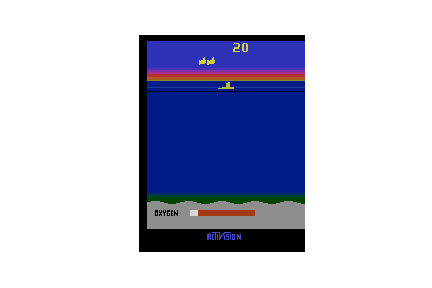
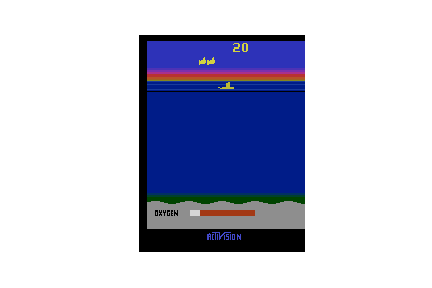
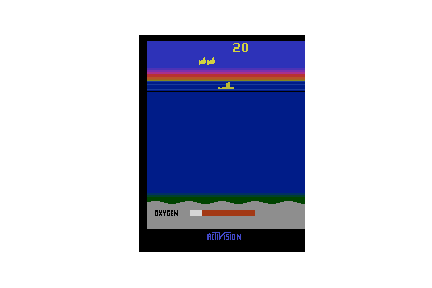
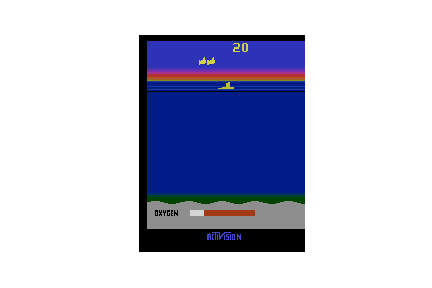
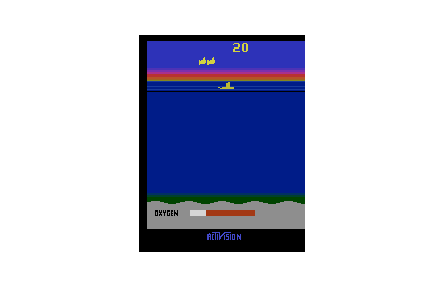
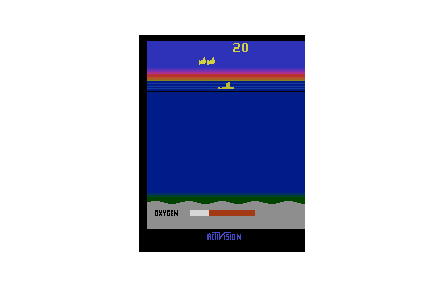
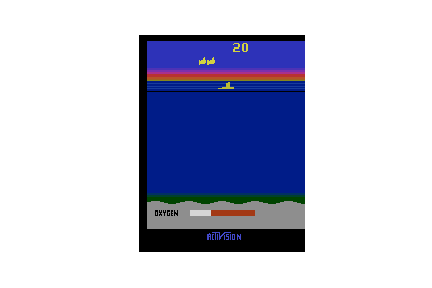
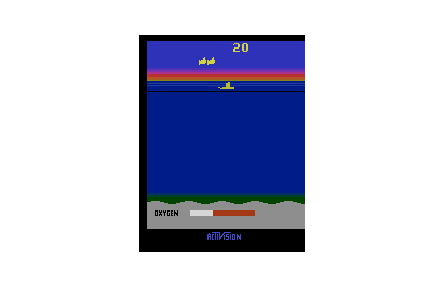
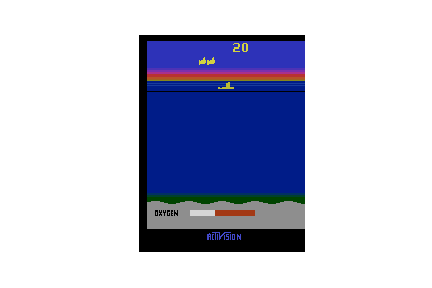
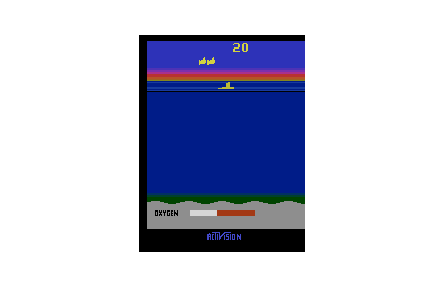
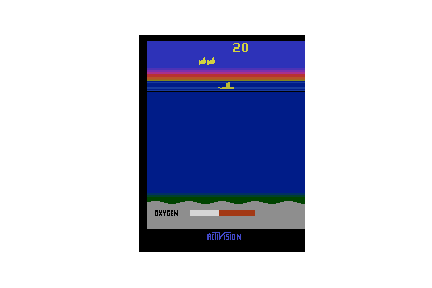
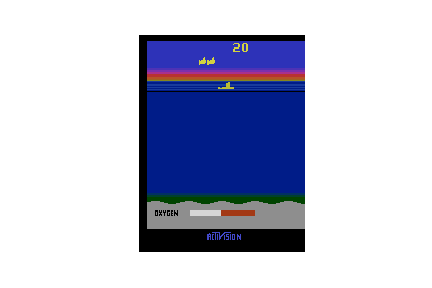
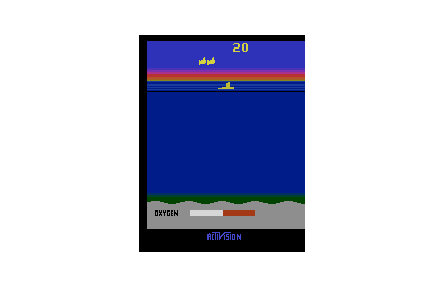
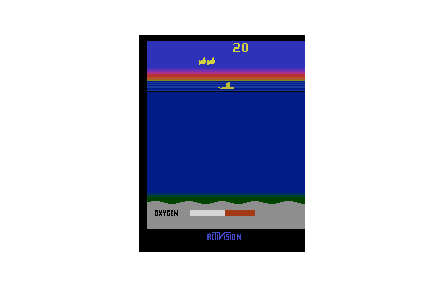
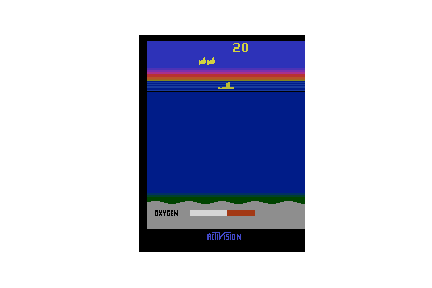
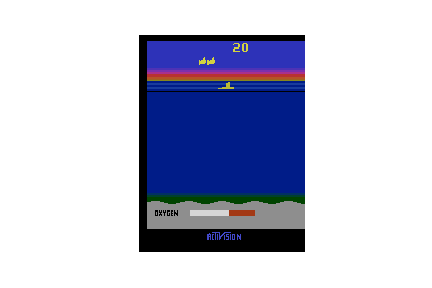
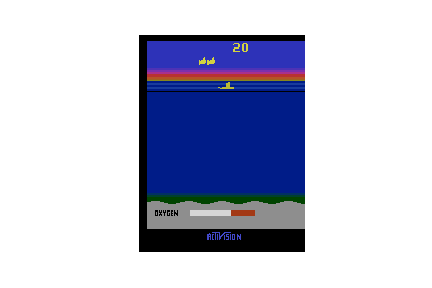
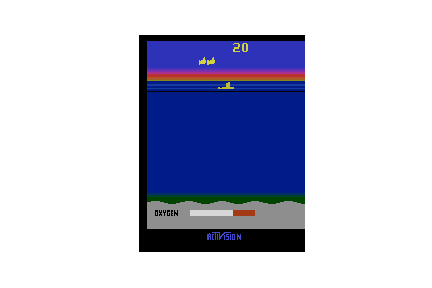
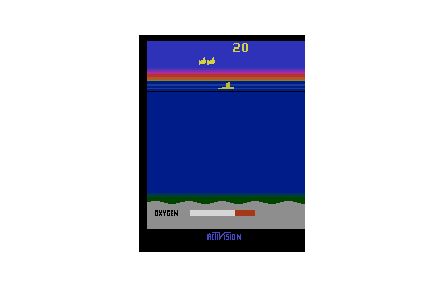
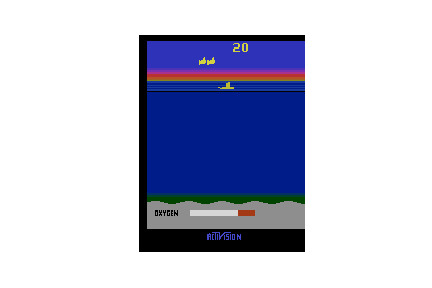
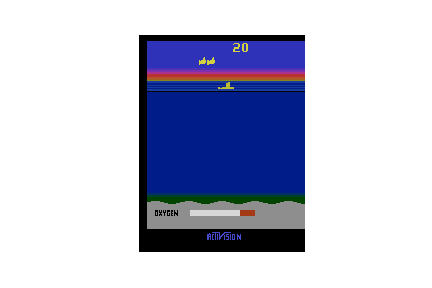
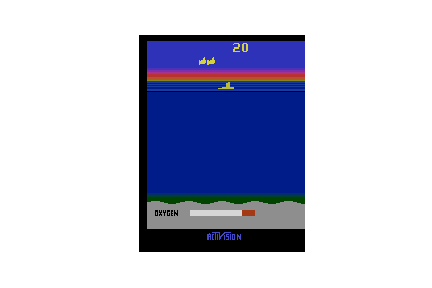
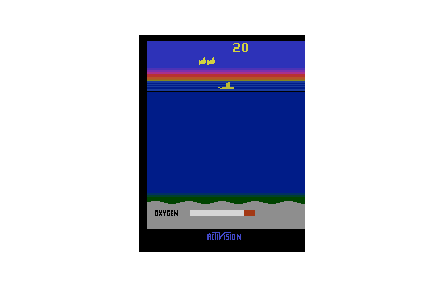
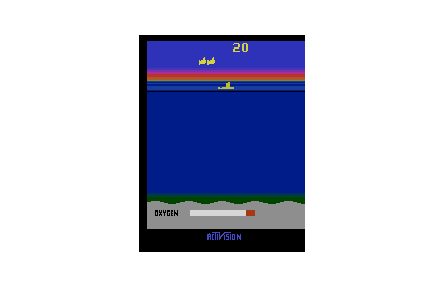
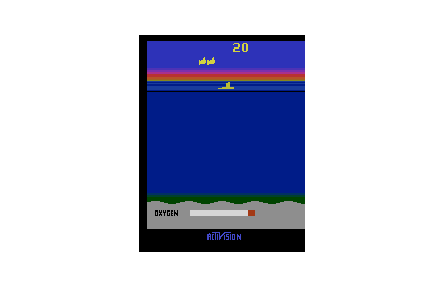
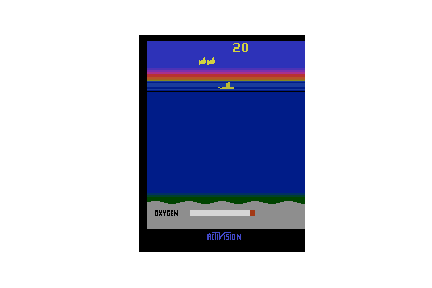
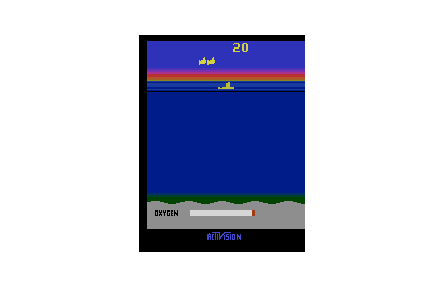
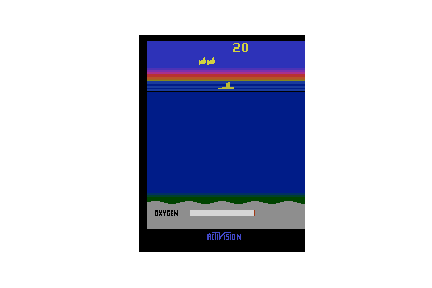
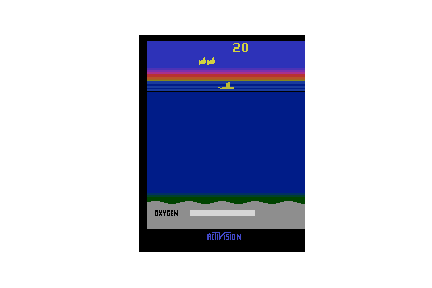
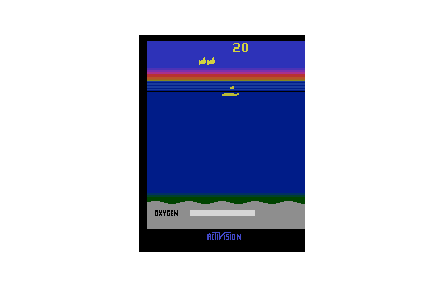
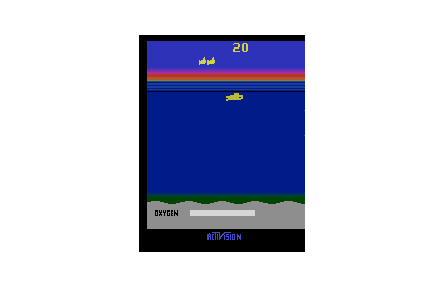
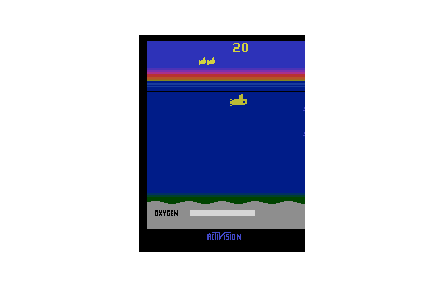
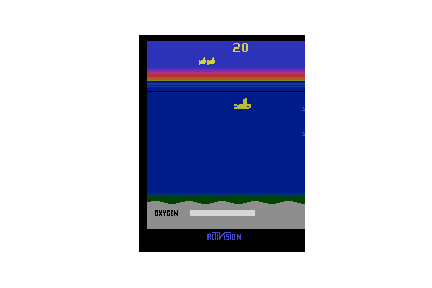
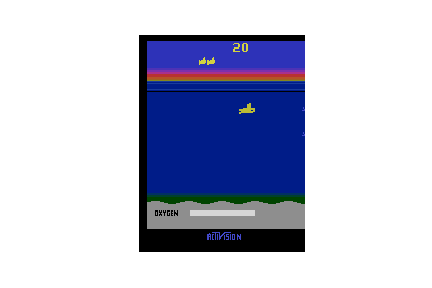
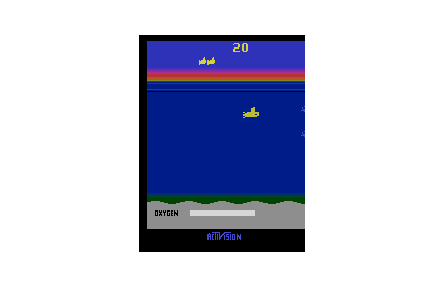
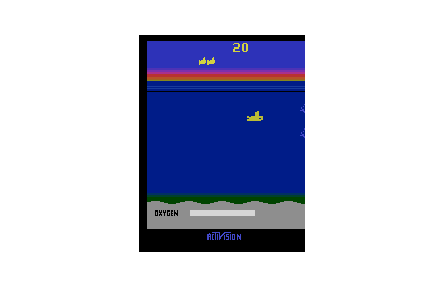
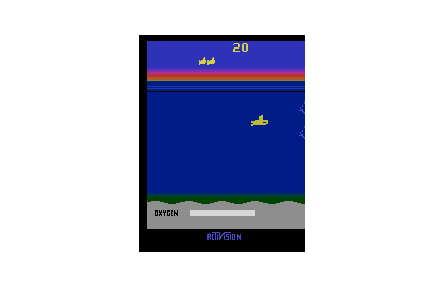
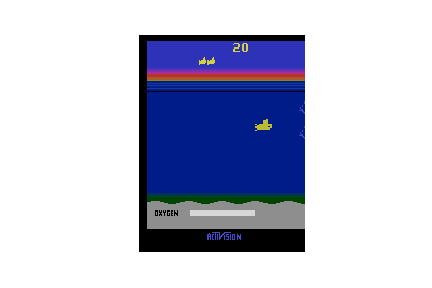
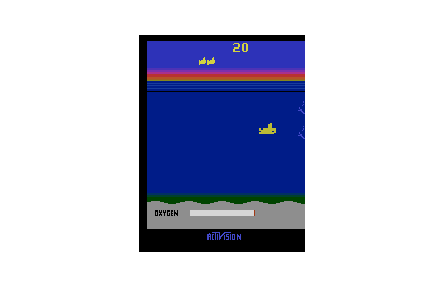
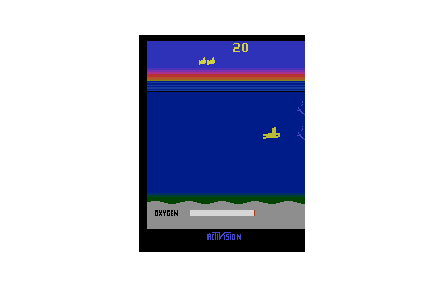
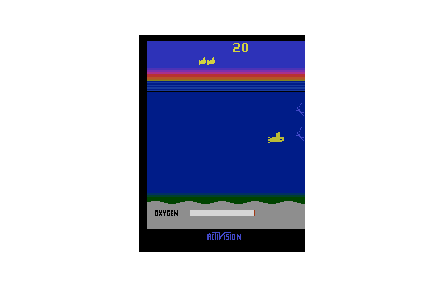
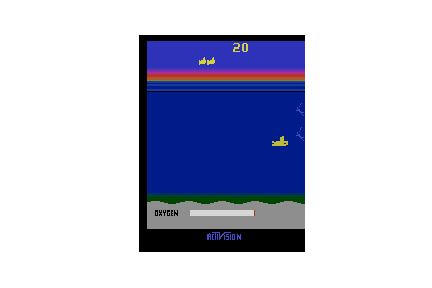
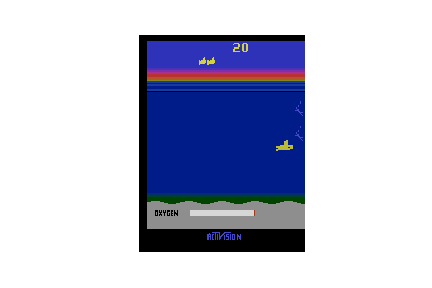
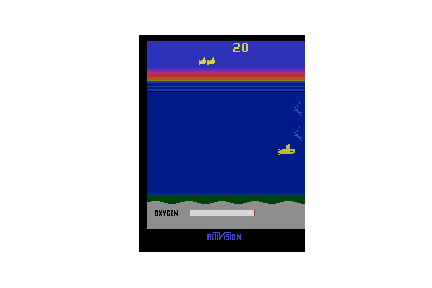
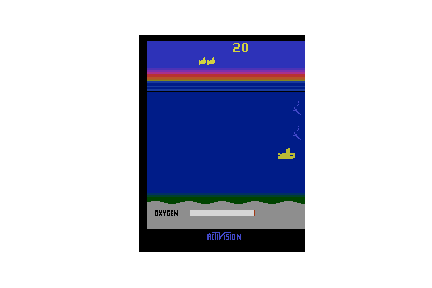
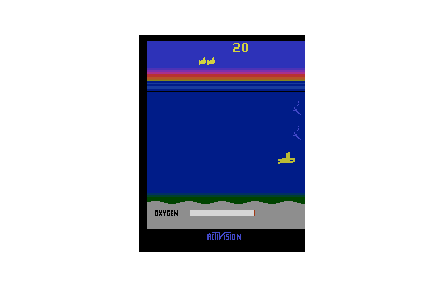
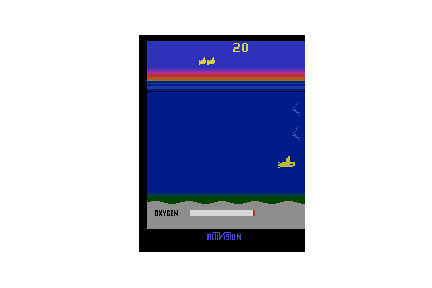
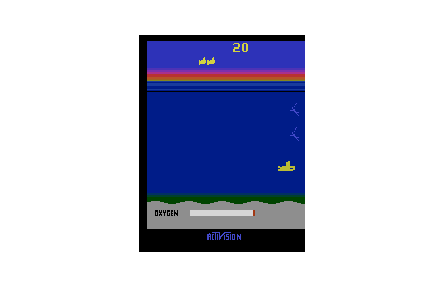
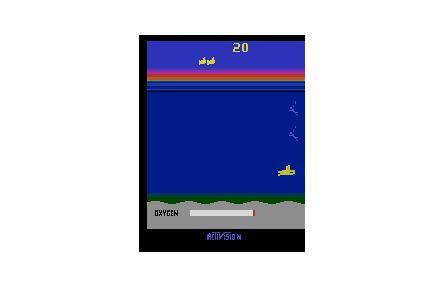
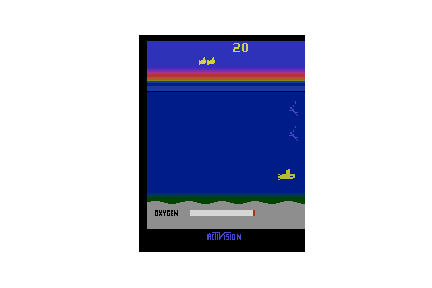
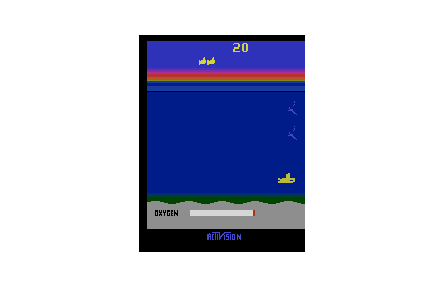
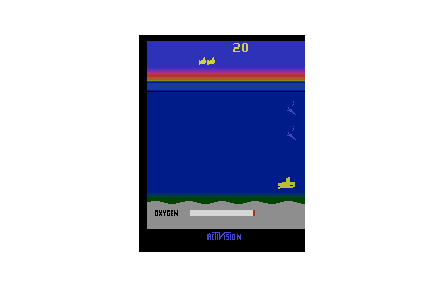
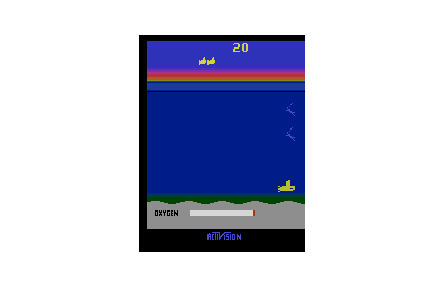
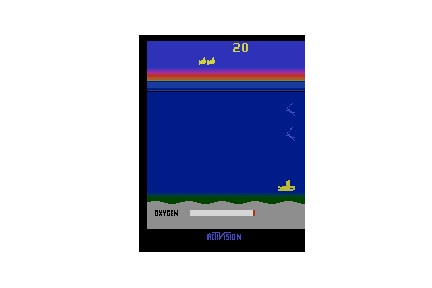
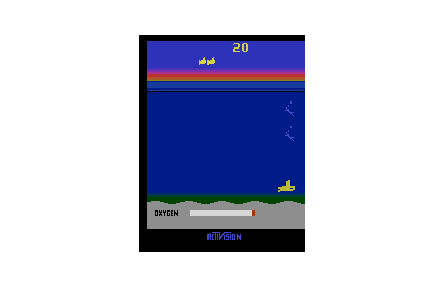
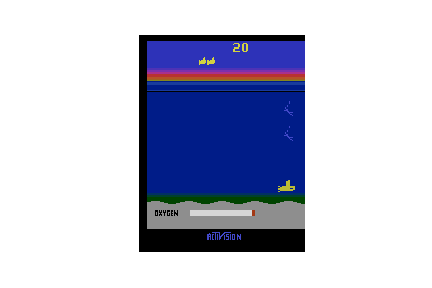
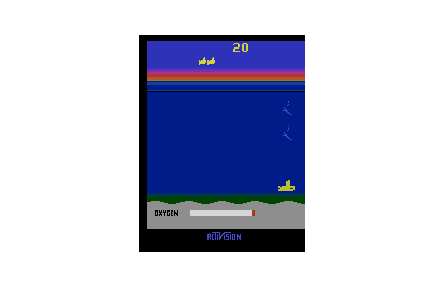
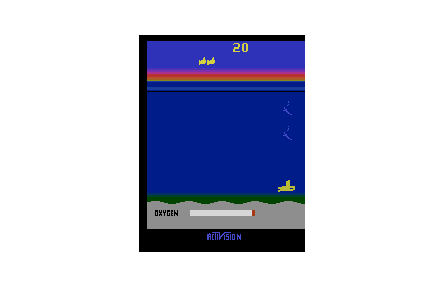
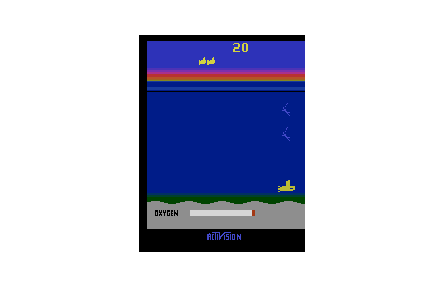
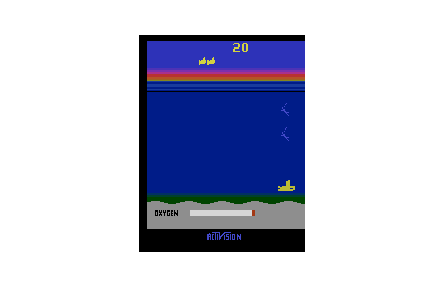
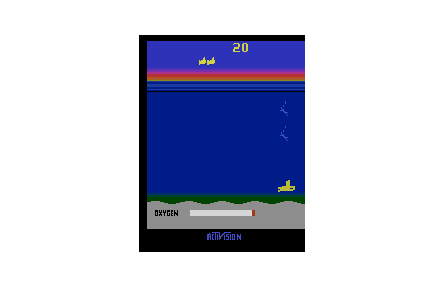
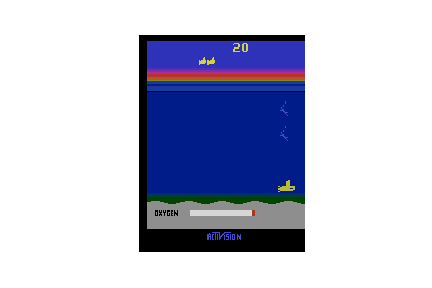
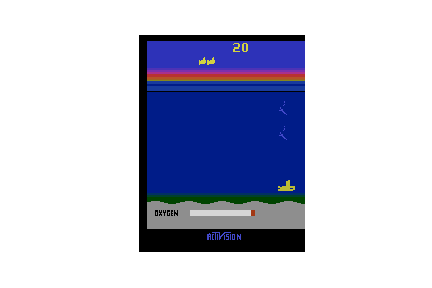
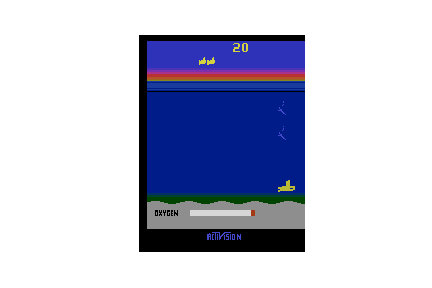
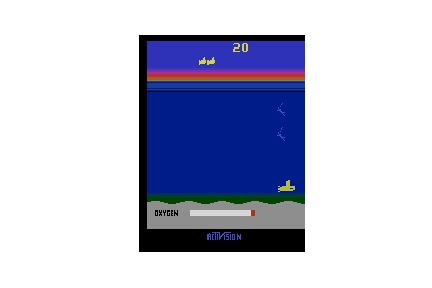
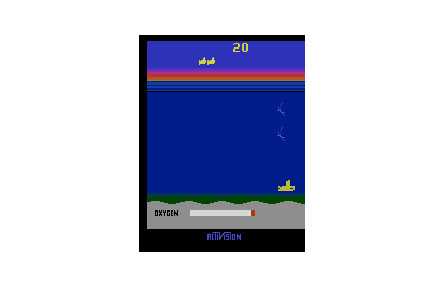
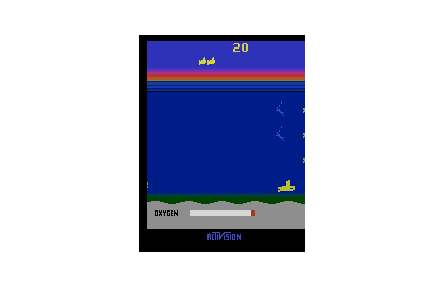
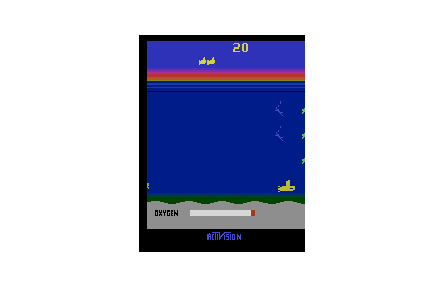
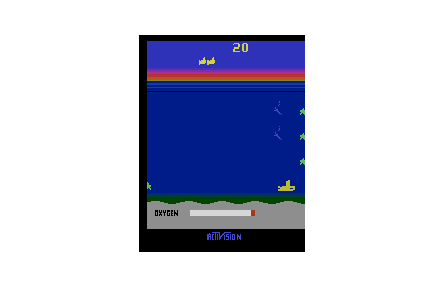
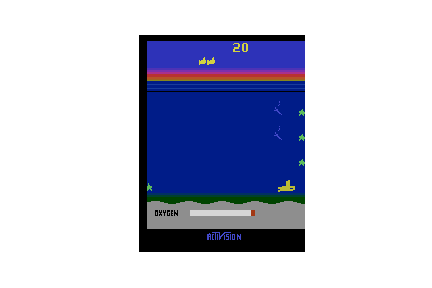
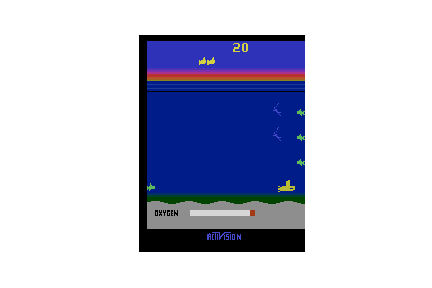
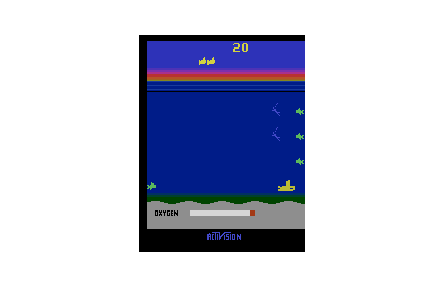
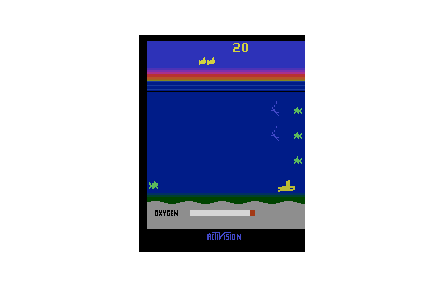
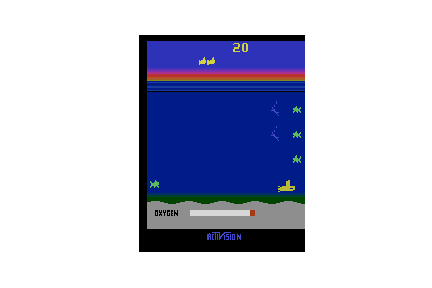
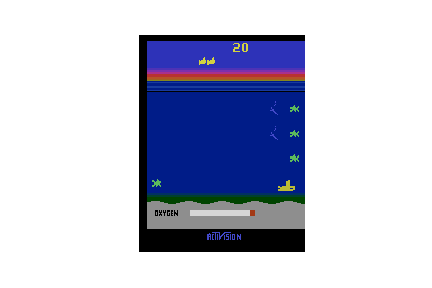
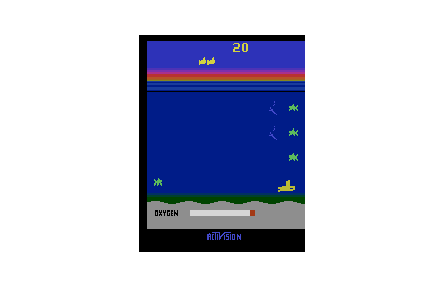
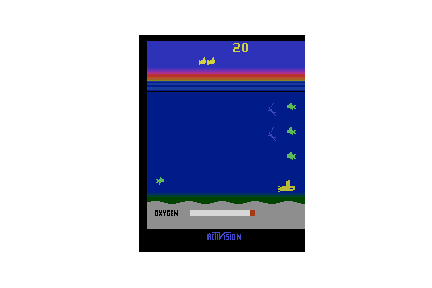
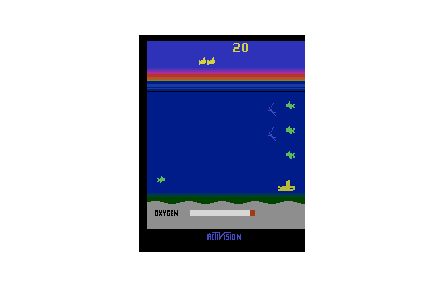
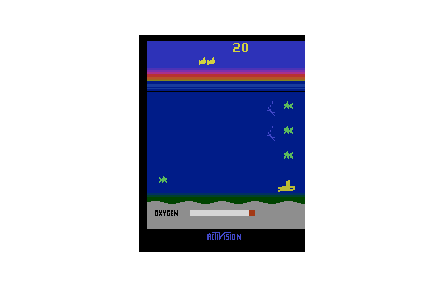
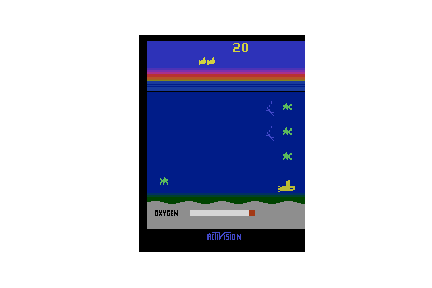
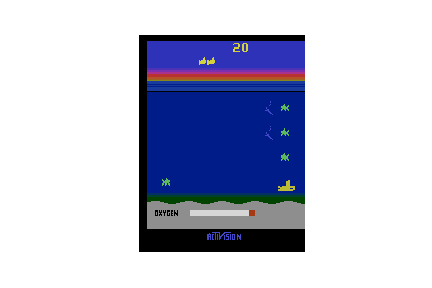
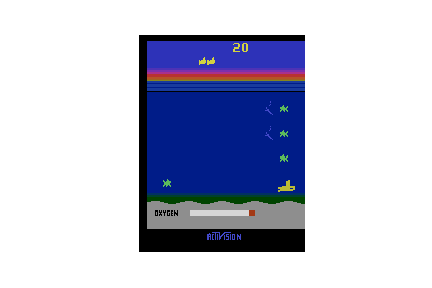
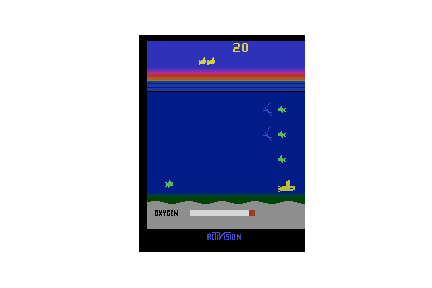
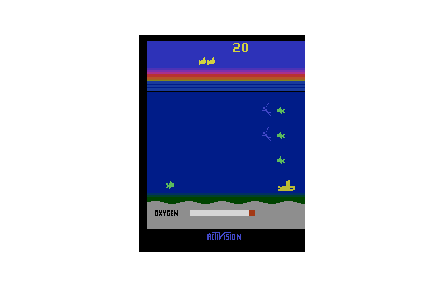
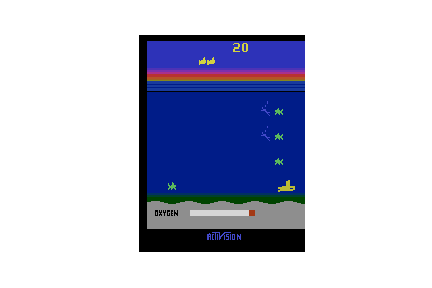
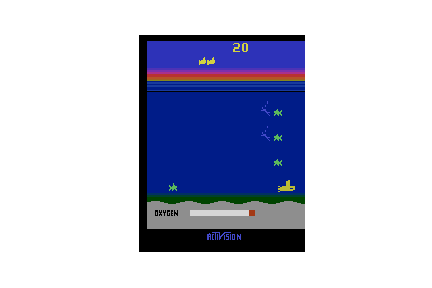
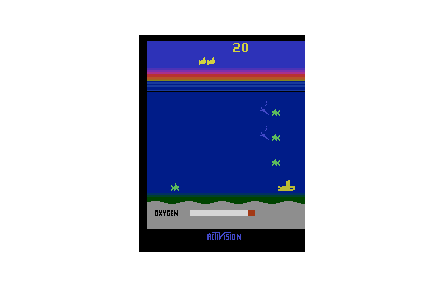
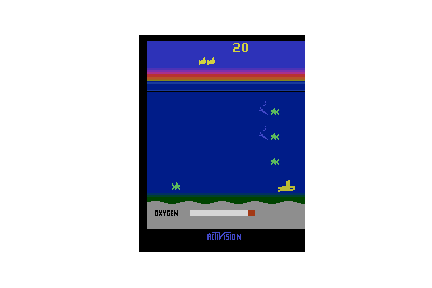
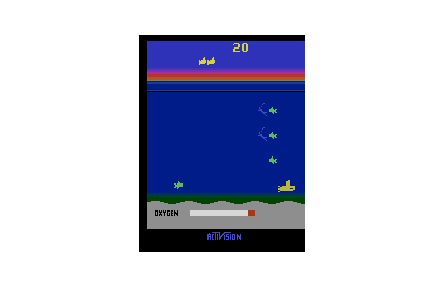
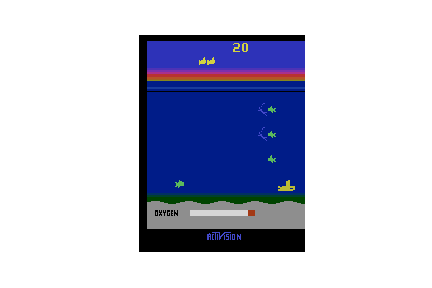
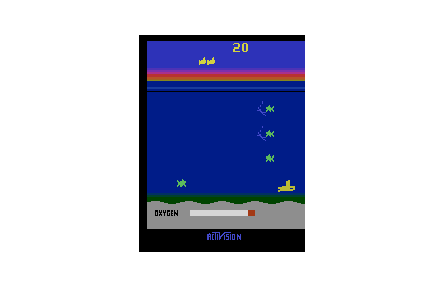
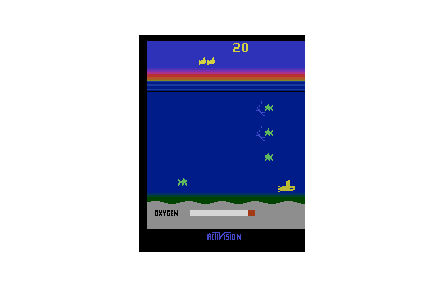
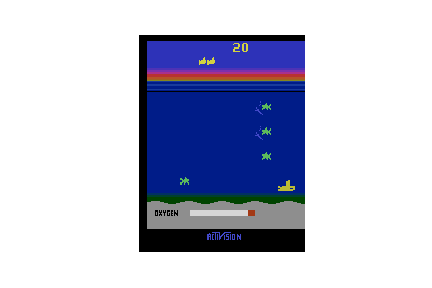
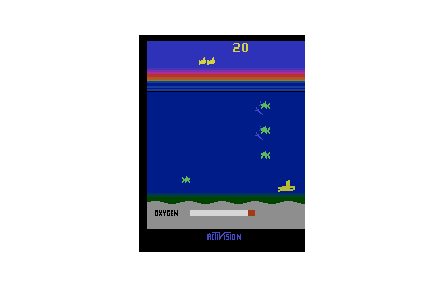
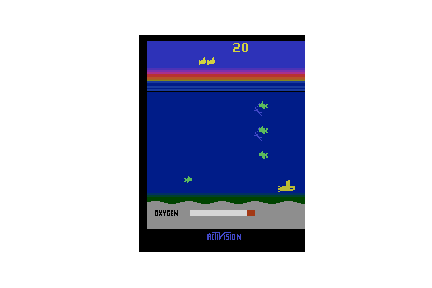
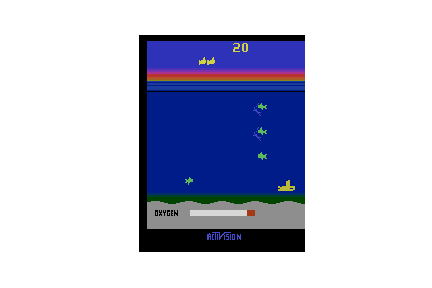
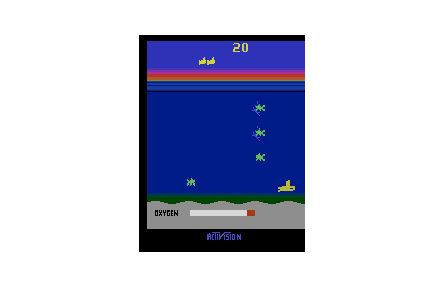
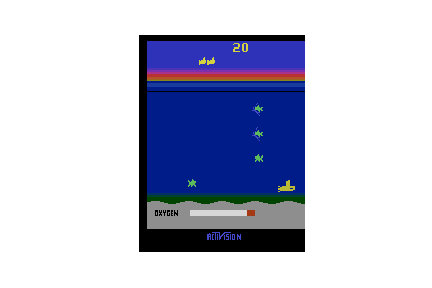
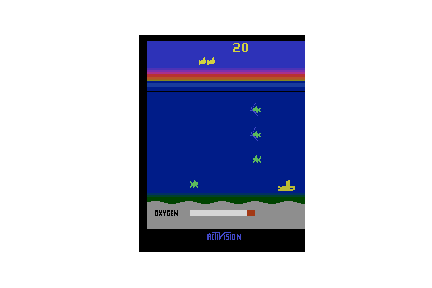
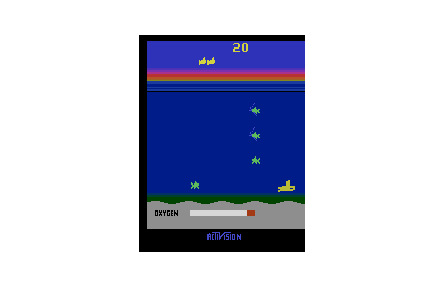
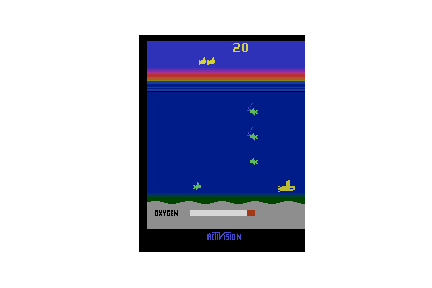
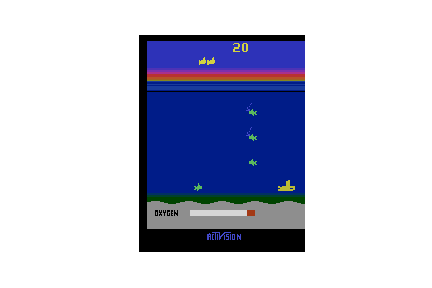
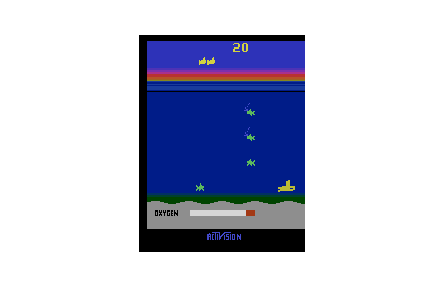
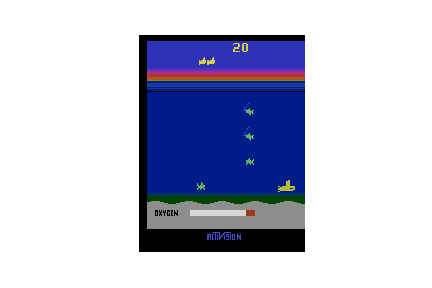
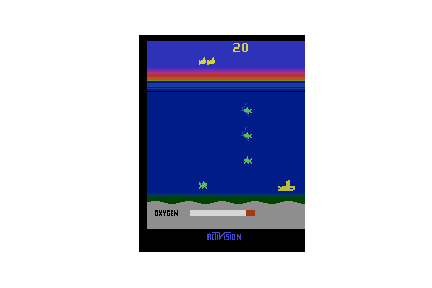
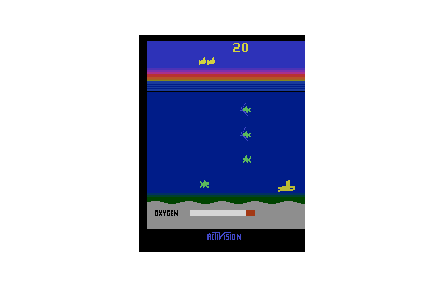
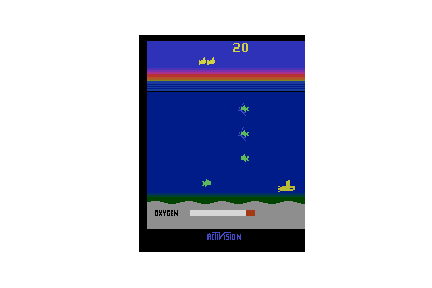
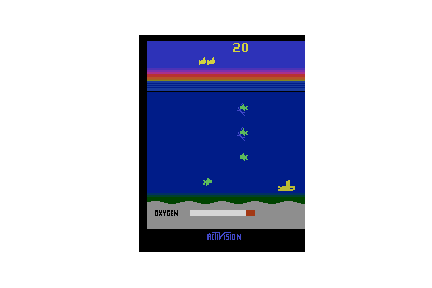
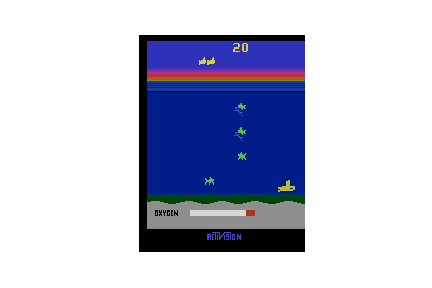
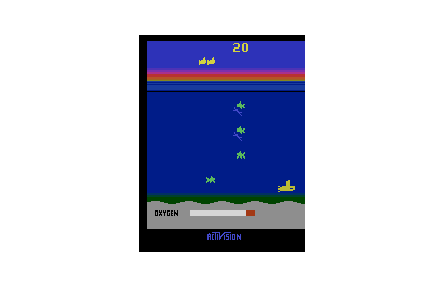
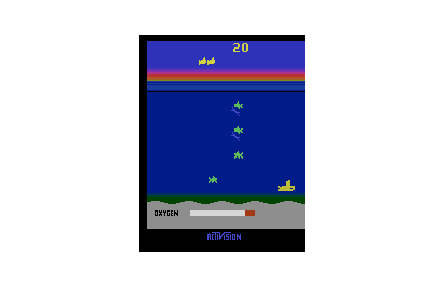
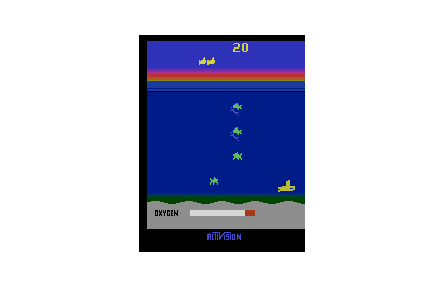
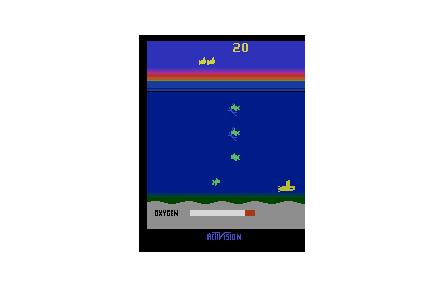
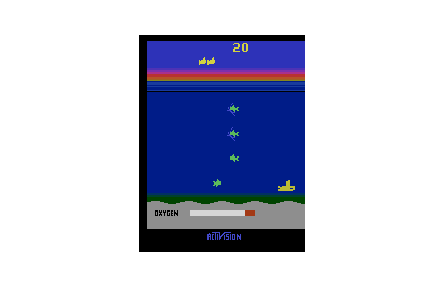
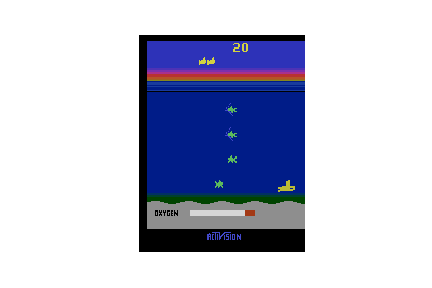
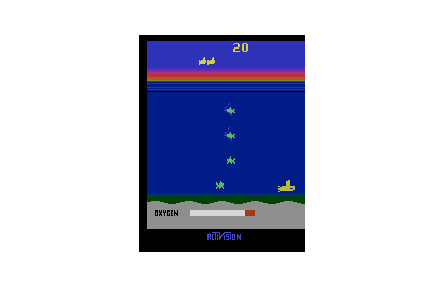
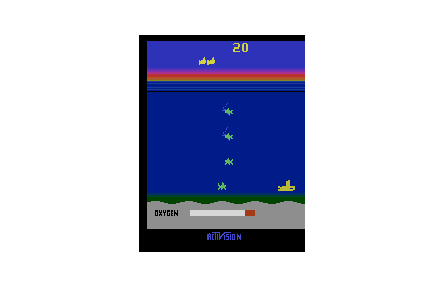
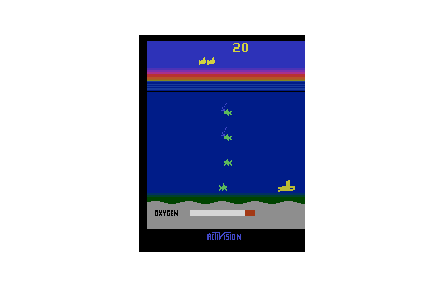
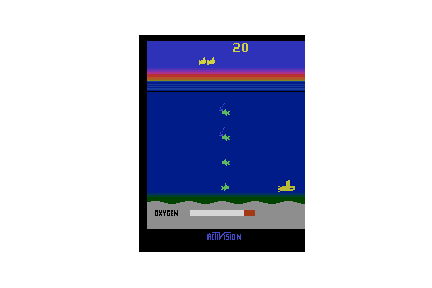
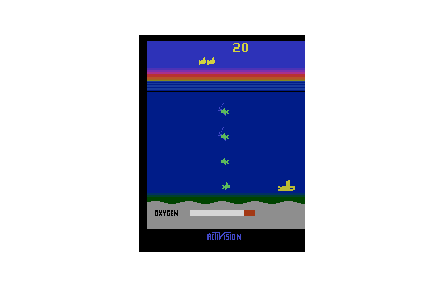
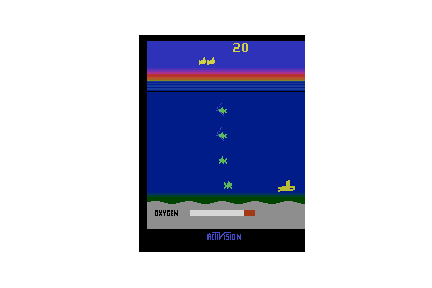
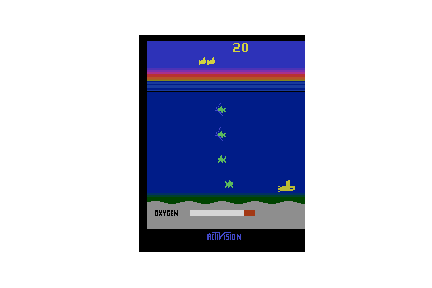
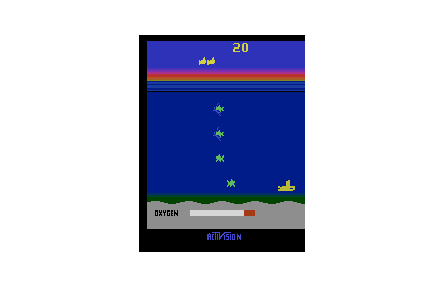
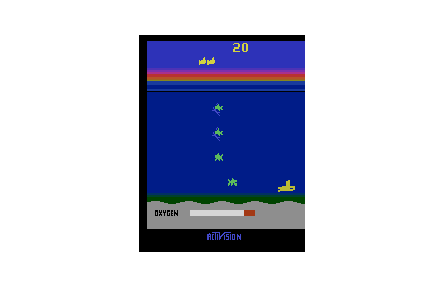
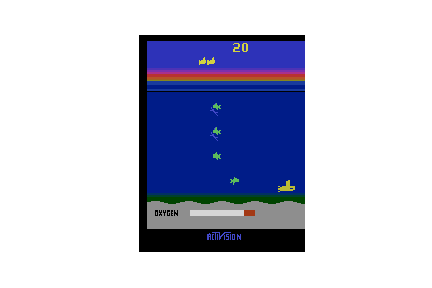
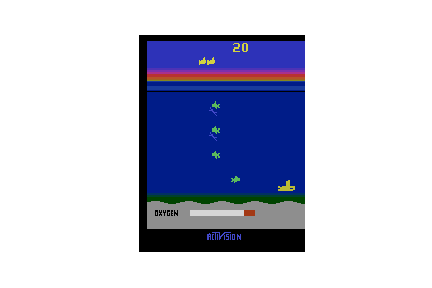
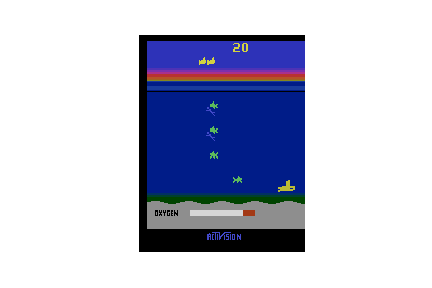
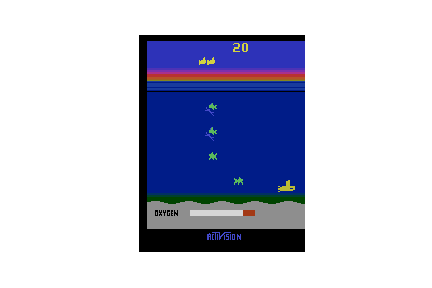
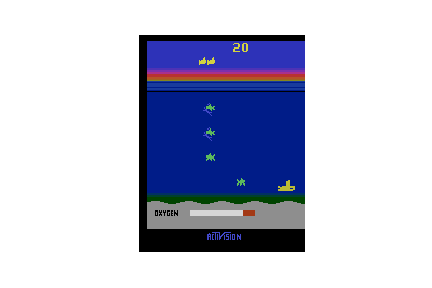
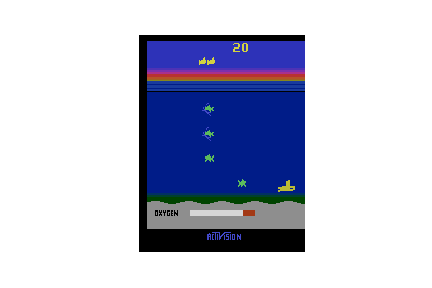
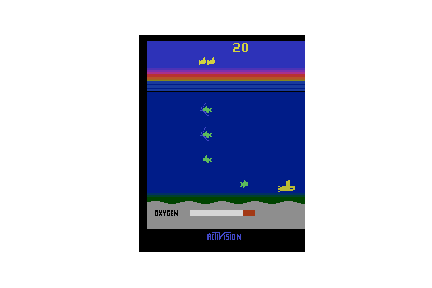
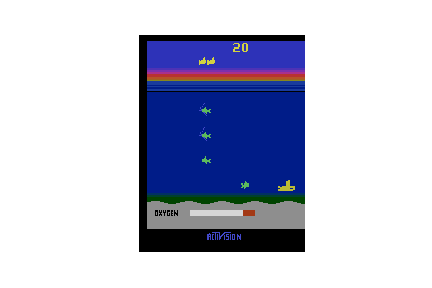
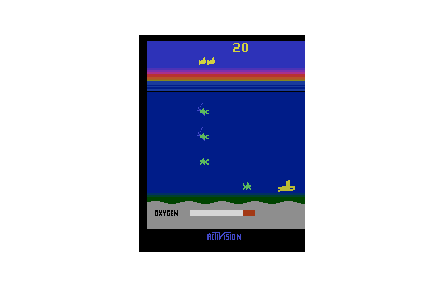
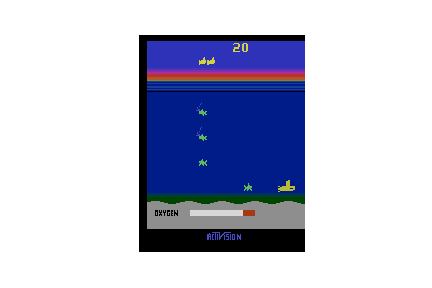
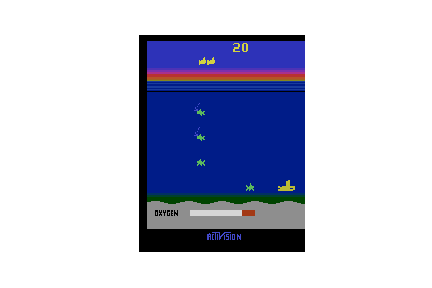
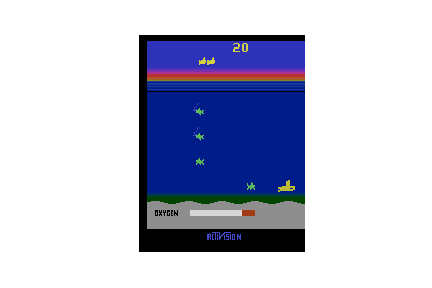
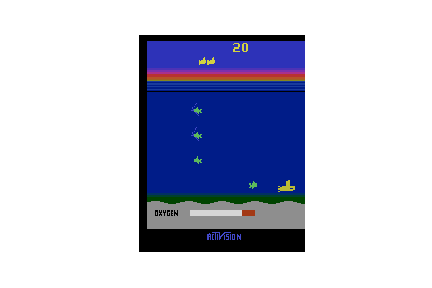
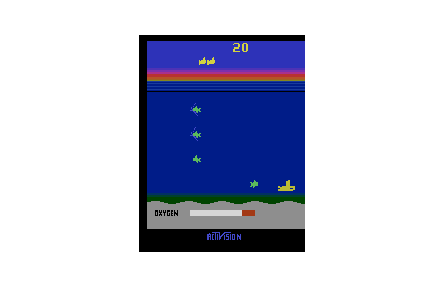
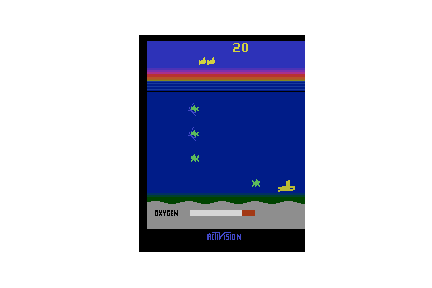
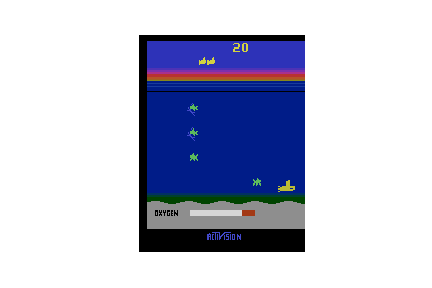
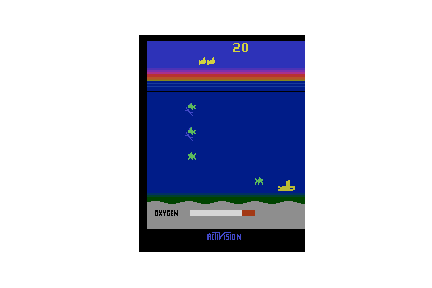
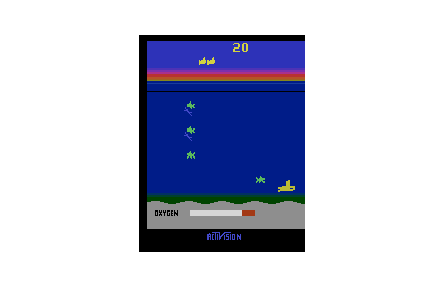
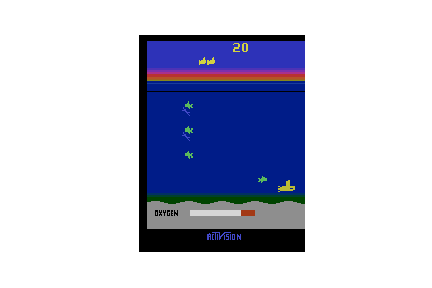
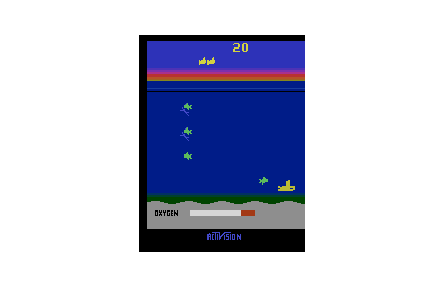
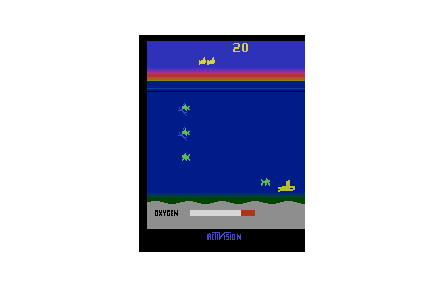
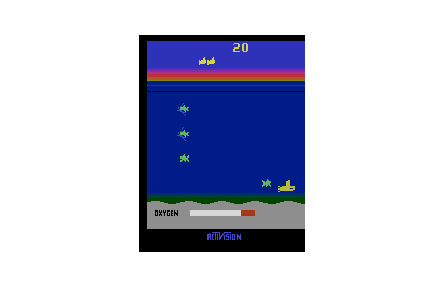
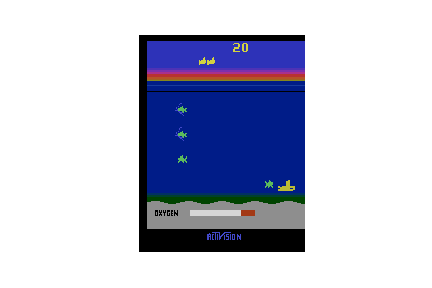
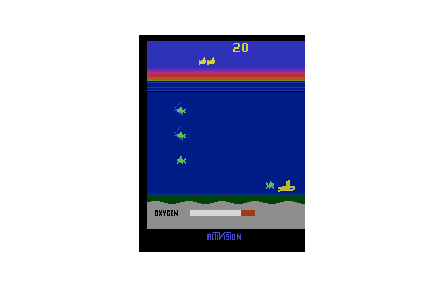
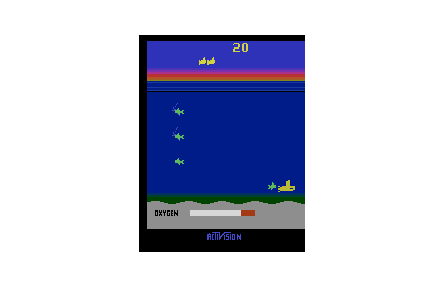
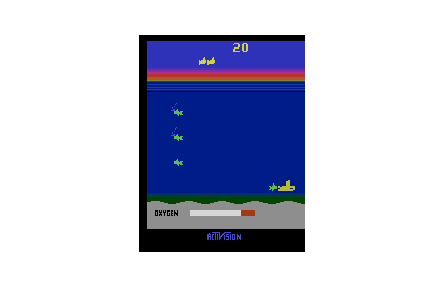
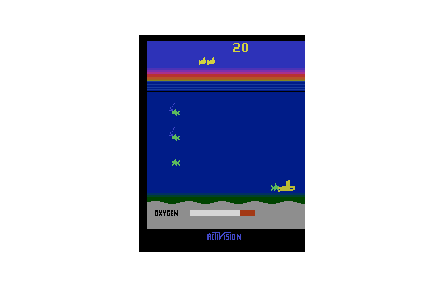
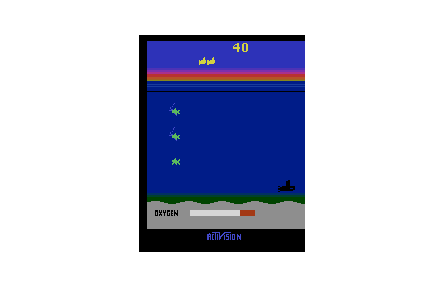
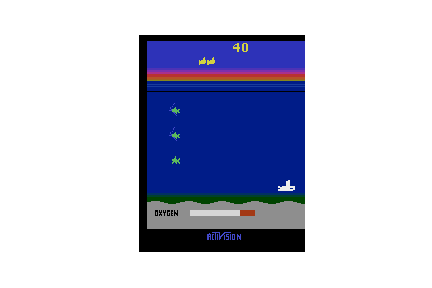
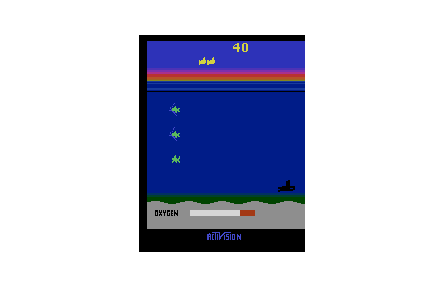
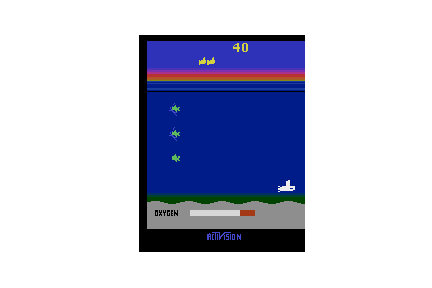
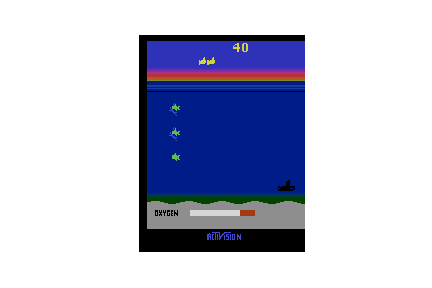
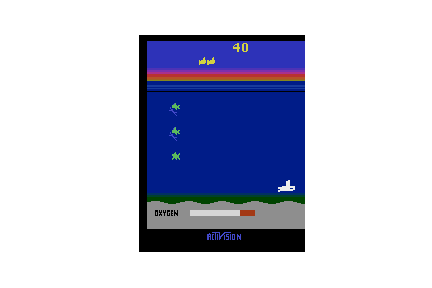
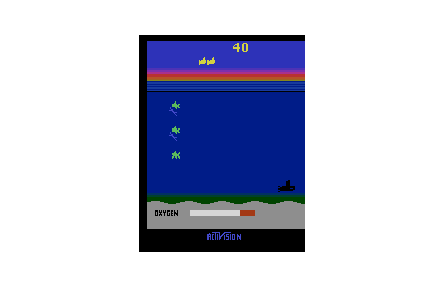
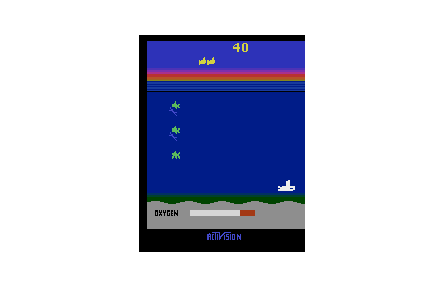
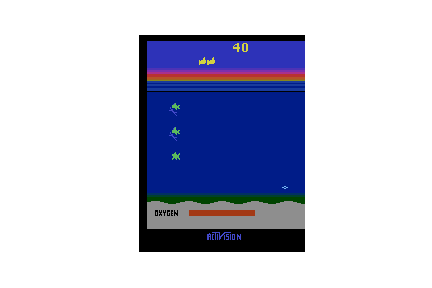
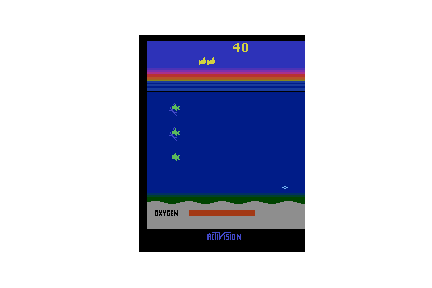
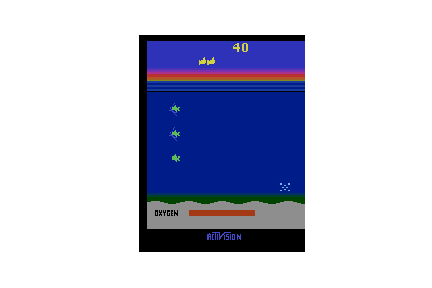
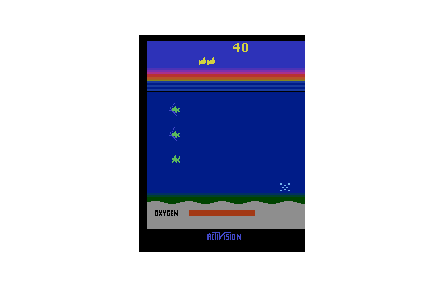
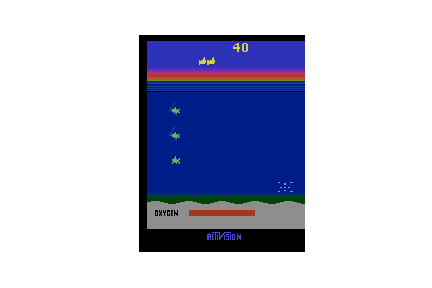
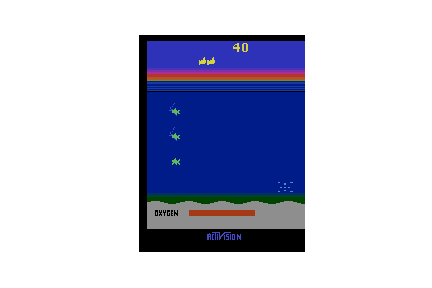
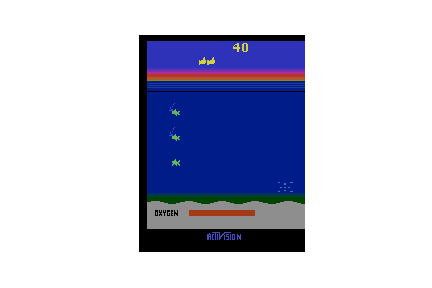
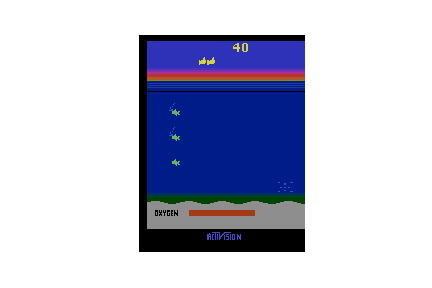
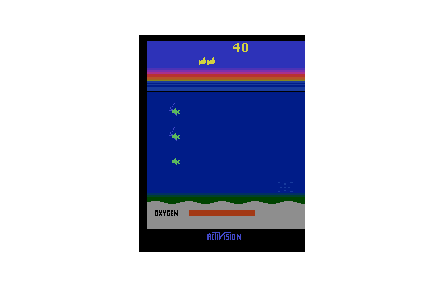
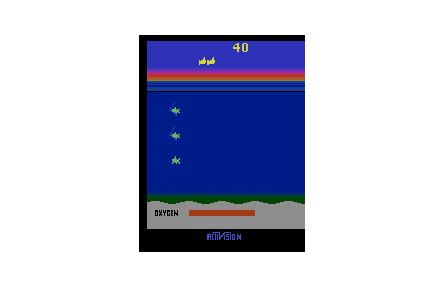
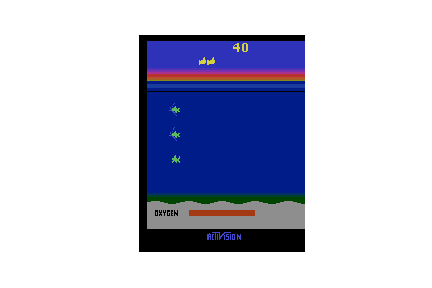
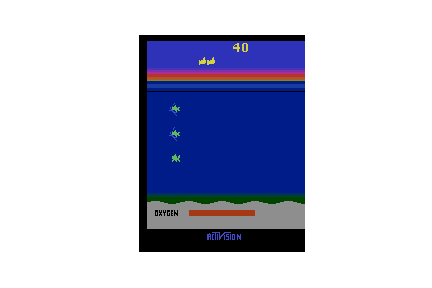
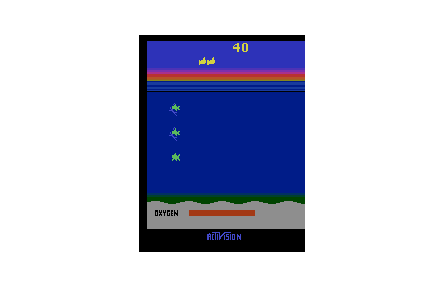
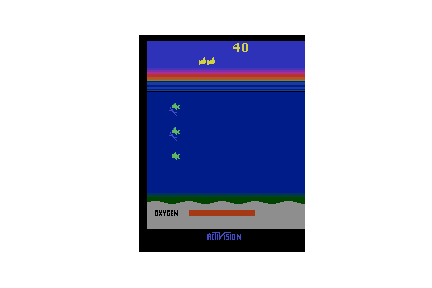
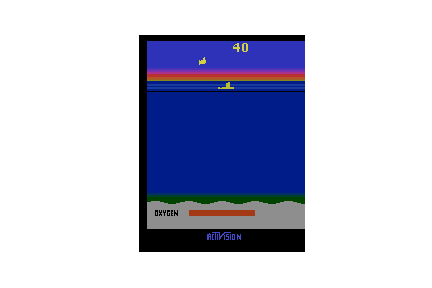

In [0]:
plot_animation(frames)

In [0]:
!pip install JSAnimation

In [0]:
#import gym
#import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=10)
    display(display_animation(anim, default_mode='loop'))

In [0]:
display_frames_as_gif(frames)